In [1]:
pip install yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/1c/19/bf19123baf16a55fd38cbb100b5a49380b9b6db7279987034689d11254c7/yfinance-0.2.32-py2.py3-none-any.whl.metadata
  Using cached yfinance-0.2.32-py2.py3-none-any.whl.metadata (11 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
  Obtaining dependency information for lxml>=4.9.1 from https://files.pythonhosted.org/packages/3c/d2/11533f0bc47ff4d828a20cfb702f3453fe714bd5b475fcdc8cec6e6b7dcf/lxml-4.9.3-cp310-cp310-manylinux_2_28_x86_64.whl.metadata
  Using cached lxml-4.9.3-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.8 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Obtaining dependency information for frozendict>=2.3.4 from https://files.pythonhosted.org/packages/86/e6/9cad8aef50f4e7c36a3f3a5c3c73b4596f721d102410c4400ff4d2f2b904/frozendict-2.3.9-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached frozendict-2.3.9-cp310-cp310-many

In [2]:
pip install tensorflow

  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Obtaining dependency information for libclang>=13.0.0 from https://files.pythonhosted.org/packages/ea/df/55525e489c43f9dbb6c8ea27d8a567b3dcd18a22f3c45483055f5ca6611d/libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl.metadata
  Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
Using cached libclang-16.0.6-py2.py3-none-manylinux2010_x86_64.whl (22.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [32]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from google.cloud import bigquery
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math
import pickle
from sklearn.metrics import mean_squared_error
from numpy import array

In [5]:
client = bigquery.Client()

In [ ]:
def Download_Dataset(stocks):
    df_stocks = yf.download(stocks, start='2018-01-01', end='2023-11-27')
    df_stocks = df_stocks.reset_index()
    df_stocks['Date'] = df_stocks['Date'].dt.strftime('%Y-%m-%d')
    df_stocks.insert(0, 'Stock', stocks)
    rows_to_insert = df_stocks.to_dict(orient='records')
    
    errors = client.insert_rows_json("serene-coyote-399200.Stock_Data.Stock_dataset", rows_to_insert)  # Make an API request.
    if errors == []:
        print("New rows have been added.")
    else:
        print("Encountered errors while inserting rows: {}".format(errors))
        
client = bigquery.Client()    
stocks_list=['AAPL','GOOGL','NVDA']
for stocks in stocks_list:
    Download_Dataset(stocks)

In [6]:
query = """ SELECT * FROM `serene-coyote-399200.Stock_Data.Stock_dataset` """
df_stocks = client.query(query).to_dataframe()
df_stocks

,Stock,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2018-01-02,42.540001,43.075001,42.314999,43.064999,40.722870,102223600
1,AAPL,2018-01-03,43.132500,43.637501,42.990002,43.057499,40.715786,118071600
2,AAPL,2018-01-04,43.134998,43.367500,43.020000,43.257500,40.904907,89738400
3,AAPL,2018-01-05,43.360001,43.842499,43.262501,43.750000,41.370621,94640000
4,AAPL,2018-01-08,43.587502,43.902500,43.482498,43.587502,41.216965,82271200
...,...,...,...,...,...,...,...,...
4450,NVDA,2023-11-17,495.239990,497.170013,490.070007,492.980011,492.980011,32520500
4451,NVDA,2023-11-20,493.119995,505.480011,491.809998,504.089996,504.089996,41412000
4452,NVDA,2023-11-21,501.260010,505.170013,492.220001,499.440002,499.440002,56574700
4453,NVDA,2023-11-22,498.519989,503.350006,476.899994,487.160004,487.160004,89942000


In [7]:
df_stocks.shape

(4455, 8)

In [8]:
df_stocks['Date'] = pd.to_datetime(df_stocks['Date'], format='%Y-%m-%d')
df_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455 entries, 0 to 4454
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Stock      4455 non-null   object        
 1   Date       4455 non-null   datetime64[ns]
 2   Open       4455 non-null   float64       
 3   High       4455 non-null   float64       
 4   Low        4455 non-null   float64       
 5   Close      4455 non-null   float64       
 6   Adj Close  4455 non-null   float64       
 7   Volume     4455 non-null   Int64         
dtypes: Int64(1), datetime64[ns](1), float64(5), object(1)
memory usage: 282.9+ KB


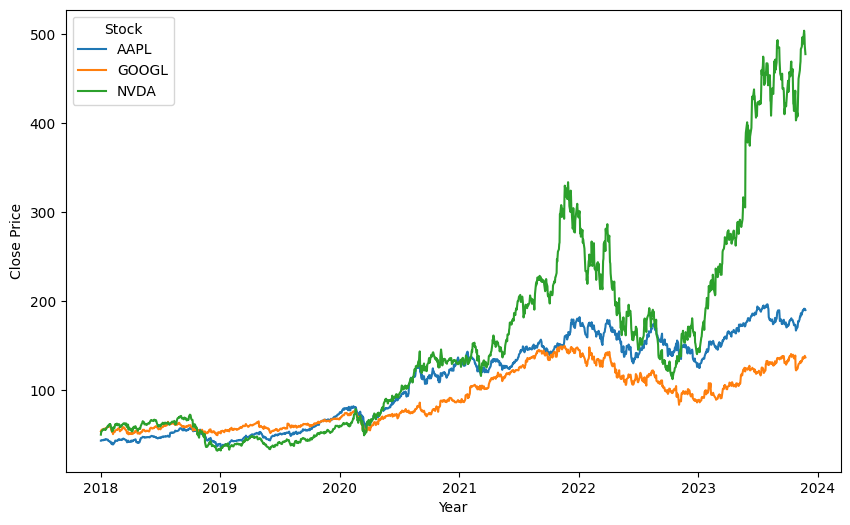

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Use sns.lineplot with hue
sns.lineplot(x='Date', y='Close', hue='Stock', data=df_stocks)

# Set labels and title
plt.xlabel("Year")
plt.ylabel("Close Price")

# Show the legend with a title
plt.legend(title='Stock')

# Show the chart
plt.show()

In [37]:
def data_preprocess(df):

    df = df.set_index('Date')

    data = df.filter(['Close'])

    dataset = data.values

    training_data_len=math.ceil(len(dataset)* .8)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    train_data = scaled_data[0:training_data_len, :]

    x_train=[]
    y_train=[]

    for i in range(60,len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i,0])

    #convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train),np.array(y_train)

    #Reshape the data
    x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1], 1))
    
    return scaled_data,train_data,x_train,y_train,training_data_len,dataset,data,scaler

df_apple= df_stocks.loc[df_stocks['Stock']=='AAPL']
scaled_data_apple,train_data_apple,x_train_apple,y_train_apple,training_data_len_apple,dataset_apple,data_apple,scaler_apple=data_preprocess(df_apple)

df_google= df_stocks.loc[df_stocks['Stock']=='GOOGL']
scaled_data_google,train_data_google,x_train_google,y_train_google,training_data_len_google,dataset_google,data_google,scaler_google=data_preprocess(df_google)

df_nvidia= df_stocks.loc[df_stocks['Stock']=='NVDA']
scaled_data_nvidia,train_data_nvidia,x_train_nvidia,y_train_nvidia,training_data_len_nvidia,dataset_nvidia,data_nvidia,scaler_nvidia=data_preprocess(df_nvidia)

LSTM model building

In [ ]:
def model(name,x_train,y_train):
    model = Sequential()
    model.add(LSTM(50,return_sequences=True, input_shape = (x_train.shape[1],1)))
    model.add(LSTM(50,return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer ='adam', loss ='mean_squared_error')
    model.fit(x_train,y_train,batch_size=1, epochs=10)

    name = model_name+".pkl"
    with open(name, 'wb') as file:
        pickle.dump(model, file)

apple_model = model_creation("apple_model1",x_train_apple,y_train_apple)
google_model = model_creation("google_model1",x_train_google,y_train_google)
nvidia_model = model_creation("nvidia_model1",x_train_nvidia,y_train_nvidia)

In [ ]:
with open('apple_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
    
test_data = scaled_data[training_data_len-60: , :]
#create the dataset x_test and y_test
x_test=[]
y_test = dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
x_test = np.array(x_test)

#reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

#get the model predicted price values
predictions = loaded_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [17]:
def prediction(pkl_file,scaled_data,training_data_len,dataset):
    
    with open(pkl_file, 'rb') as file:
        loaded_model = pickle.load(file)

    test_data = scaled_data[training_data_len-60: , :]
    #create the dataset x_test and y_test
    x_test=[]
    y_test = dataset[training_data_len:,:]
    for i in range(60,len(test_data)):
        x_test.append(test_data[i-60:i,0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

    predictions = loaded_model.predict(x_test)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    predictions = scaler.inverse_transform(predictions)
    
    return x_test,y_test,predictions

x_test_apple,y_test_apple,predictions_apple= prediction('apple_model.pkl',scaled_data_apple,training_data_len_apple,dataset_apple)
x_test_google,y_test_google,predictions_google= prediction('google_model.pkl',scaled_data_google,training_data_len_google,dataset_google)
x_test_nvidia,y_test_nvidia,predictions_nvidia= prediction('nvidia_model.pkl',scaled_data_nvidia,training_data_len_nvidia,dataset_nvidia)

10/10 [==============================] - 1s 13ms/step


In [21]:
def RMSE(name,pkl_file,x_train,dataset,y_test,predictions):
    
    with open(pkl_file, 'rb') as file:
        loaded_model = pickle.load(file)
    
    Train_predictions = loaded_model.predict(x_train)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    Train_predictions = scaler.inverse_transform(Train_predictions)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(name+' RMSE:', rmse)
    return rmse

apple_RMSE_Value = RMSE('APPLE','apple_model.pkl',x_train_apple,dataset_apple,y_test_apple,predictions_apple)
google_RMSE_Value = RMSE('GOOGLE','google_model.pkl',x_train_google,dataset_google,y_test_google,predictions_google)
nvidia_RMSE_Value = RMSE('NVIDIA','nvidia_model.pkl',x_train_nvidia,dataset_nvidia,y_test_nvidia,predictions_nvidia)

36/36 [==============================] - 1s 15ms/step
APPLE RMSE: 2.658869617007606
36/36 [==============================] - 1s 14ms/step
GOOGLE RMSE: 2.8212055019451925
36/36 [==============================] - 1s 13ms/step
NVIDIA RMSE: 9.43693460647195


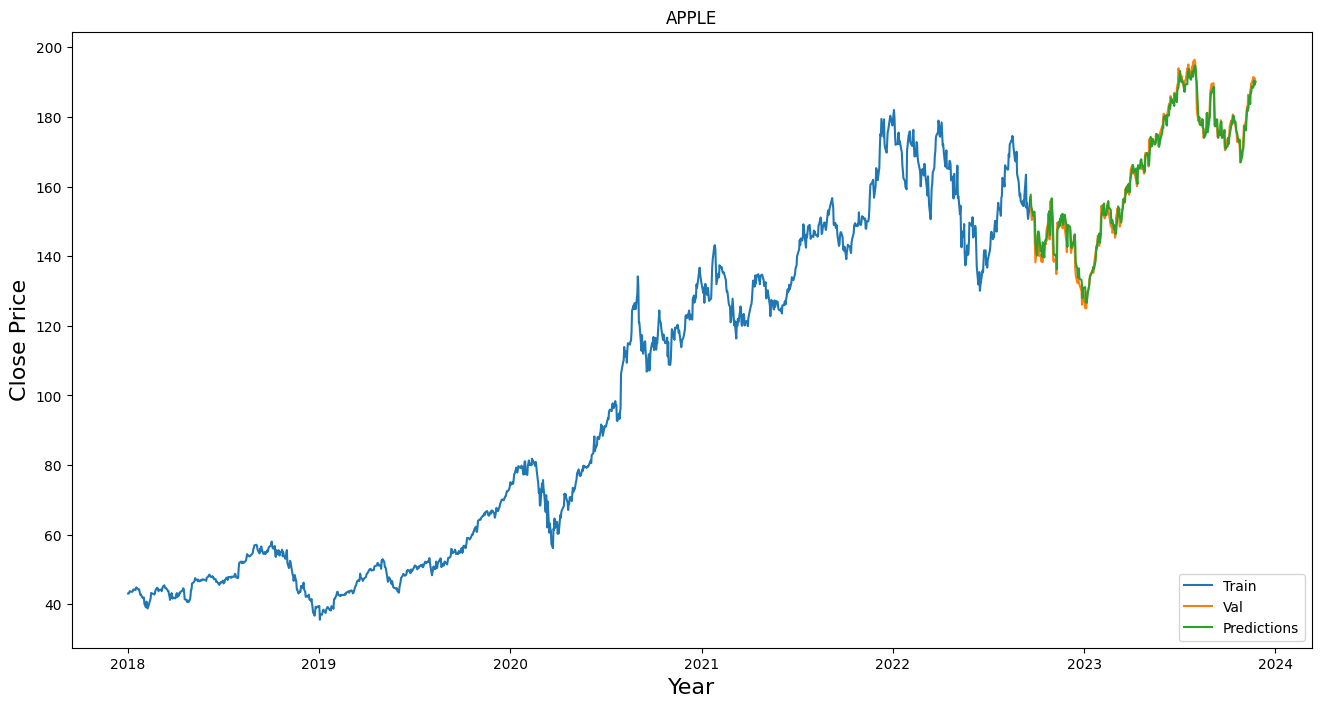

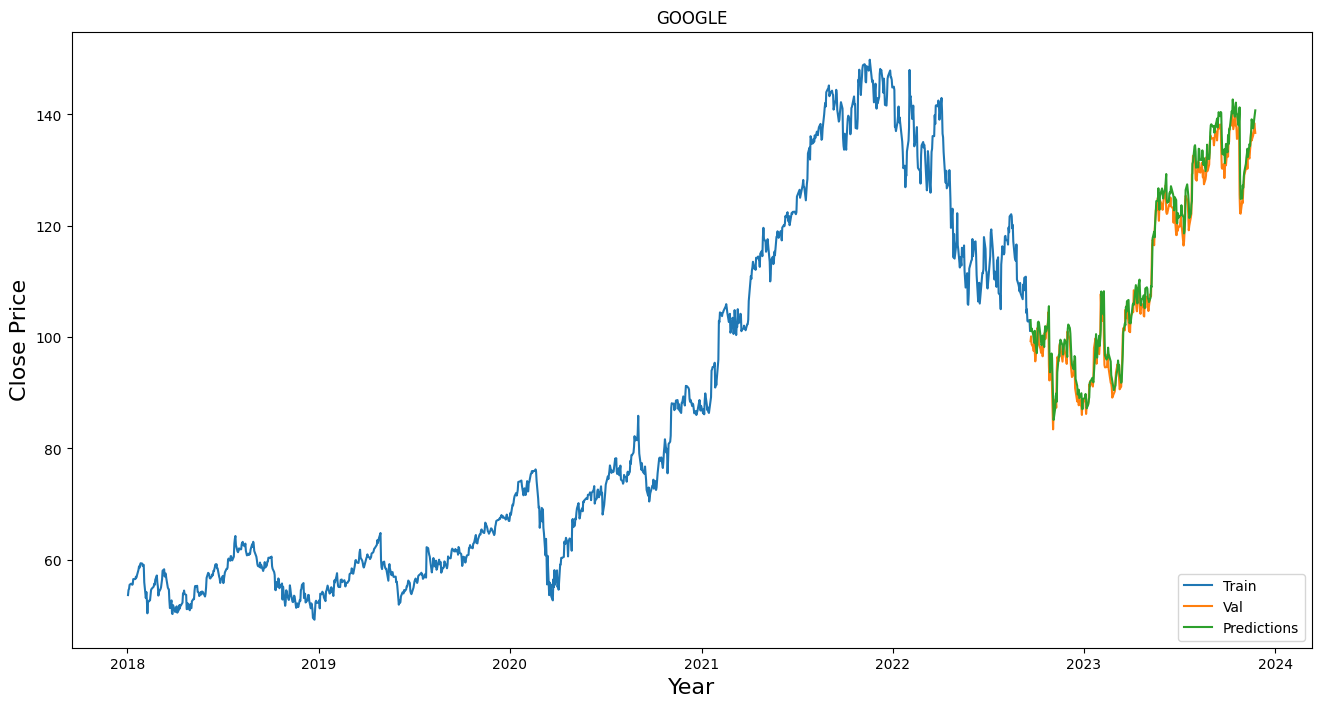

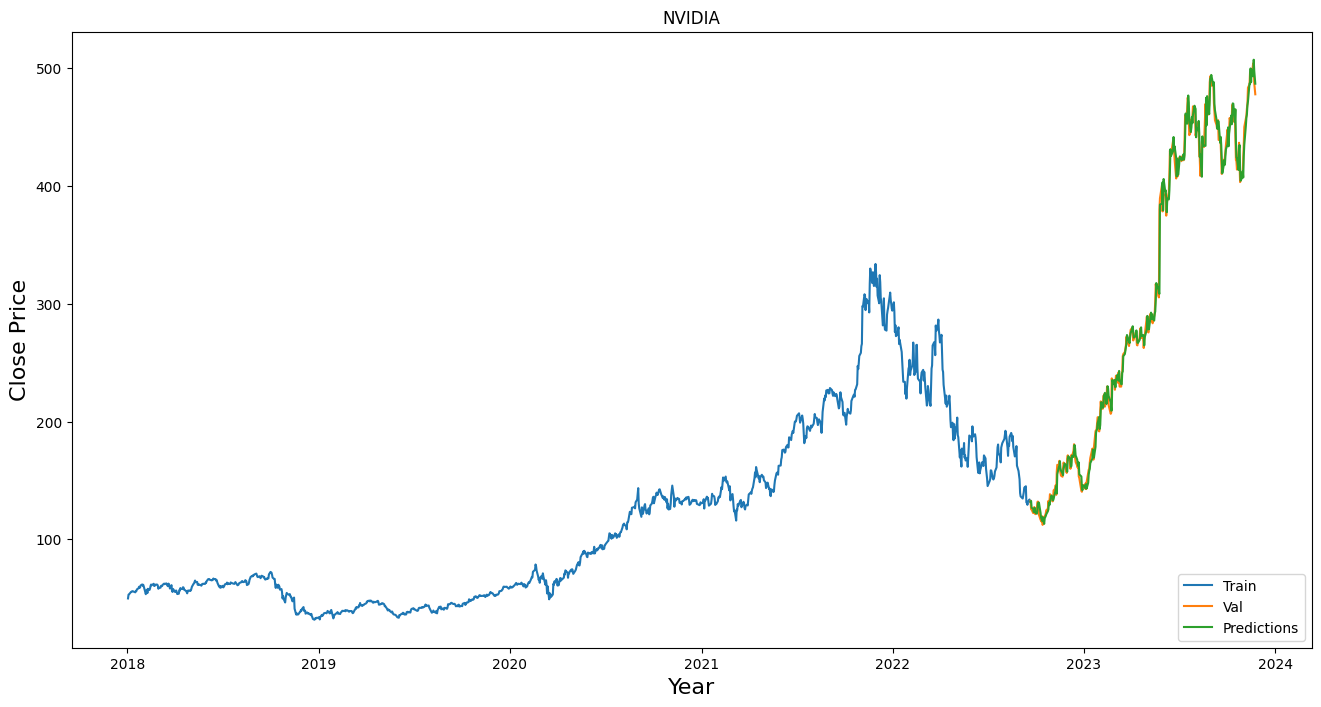

In [26]:
def visualization(name,data,training_data_len,predictions):
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid1 = valid.copy()
    valid1['Predictions'] = predictions
    #visualize the data
    plt.figure(figsize=(16,8))
    plt.title(name)
    plt.xlabel("Year", fontsize=16)
    plt.ylabel('Close Price', fontsize=16)
    plt.plot(train['Close'])
    plt.plot(valid1[['Close','Predictions']])
    plt.legend(['Train','Val','Predictions'], loc='lower right')
    plt.show()
    
    return valid1

valid_apple=visualization('APPLE',data_apple,training_data_len_apple,predictions_apple)
valid_google=visualization('GOOGLE',data_google,training_data_len_google,predictions_google)
valid_nvidia=visualization('NVIDIA',data_nvidia,training_data_len_nvidia,predictions_nvidia)

In [31]:
valid_nvidia

,Close,Predictions
Date,,
2022-09-21,132.610001,131.940109
2022-09-22,125.610001,132.572189
2022-09-23,125.160004,126.873520
2022-09-26,122.279999,125.919098
2022-09-27,124.129997,123.203674
...,...,...
2023-11-17,492.980011,498.526184
2023-11-20,504.089996,493.038849
2023-11-21,499.440002,507.115204


In [41]:
def forecast(scaled_data,pkl_file,training_data_len,scaler):
    
    with open(pkl_file, 'rb') as file:
        loaded_model = pickle.load(file)
        
    test_scale = scaled_data.reshape(-1,1)
    testing_data = test_scale[training_data_len:, :]

    x_input=testing_data[len(testing_data)-60:].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    lst_output=[]
    n_steps=60
    i=0
    while(i<100):

        if(len(temp_input)>60):
            x_input=np.array(temp_input[1:])
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = loaded_model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = loaded_model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1
            
    #scaler = MinMaxScaler(feature_range=(0,1))
    output=scaler.inverse_transform(lst_output)
    values=np.array(output)
    values=values.flatten()
    date_range = pd.date_range(start='2023-11-25', periods=len(values), freq='D')
    forecastdf = pd.DataFrame({'Date': date_range, 'Values': values})
    
    return forecastdf

forecastdf_apple=forecast(scaled_data_apple,'apple_model.pkl',training_data_len_apple,scaler_apple)
forecastdf_google=forecast(scaled_data_google,'google_model.pkl',training_data_len_google,scaler_google)
forecastdf_nvidia=forecast(scaled_data_nvidia,'nvidia_model.pkl',training_data_len_nvidia,scaler_nvidia)

In [47]:
data_apple

,Close
Date,
2018-01-02,43.064999
2018-01-03,43.057499
2018-01-04,43.257500
2018-01-05,43.750000
2018-01-08,43.587502
...,...
2023-11-17,189.690002
2023-11-20,191.449997
2023-11-21,190.639999


In [45]:
forecastdf_apple

,Date,Values
0,2023-11-25,188.526910
1,2023-11-26,187.321667
2,2023-11-27,186.285132
3,2023-11-28,185.345019
4,2023-11-29,184.469106
...,...,...
95,2024-02-28,174.305334
96,2024-02-29,174.298438
97,2024-03-01,174.291850
98,2024-03-02,174.285539


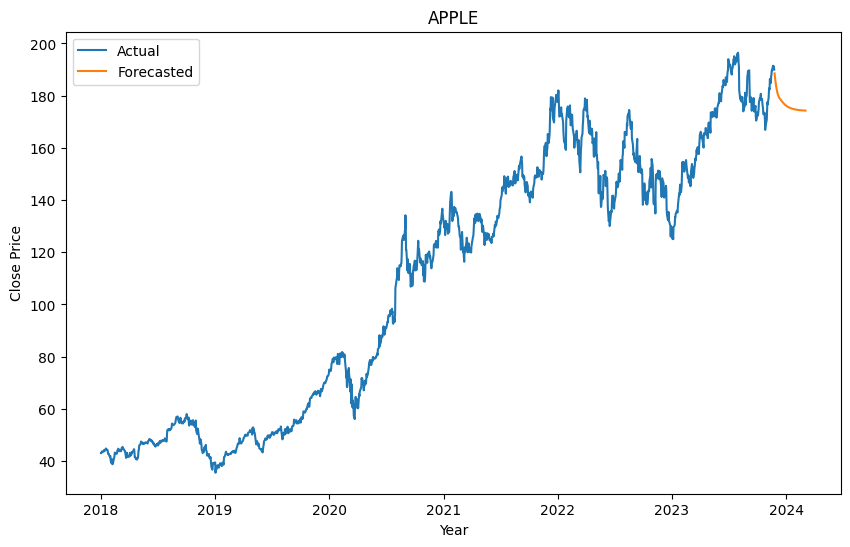

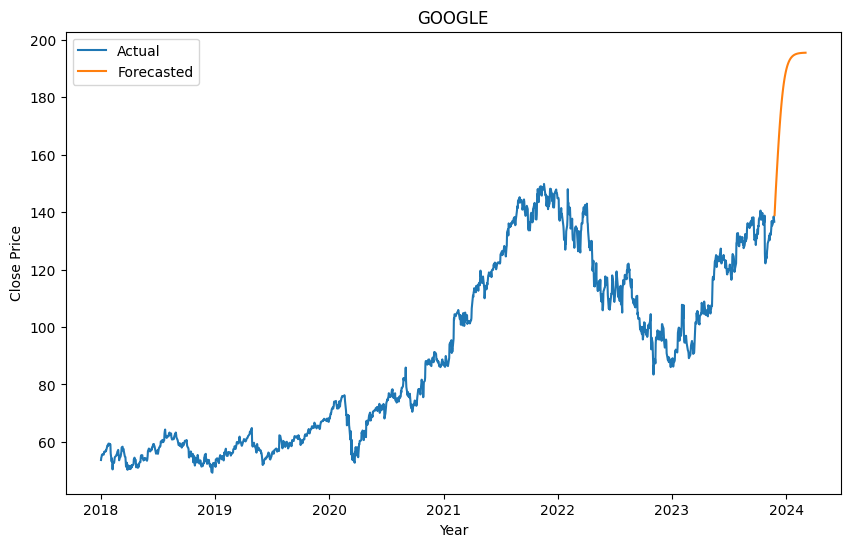

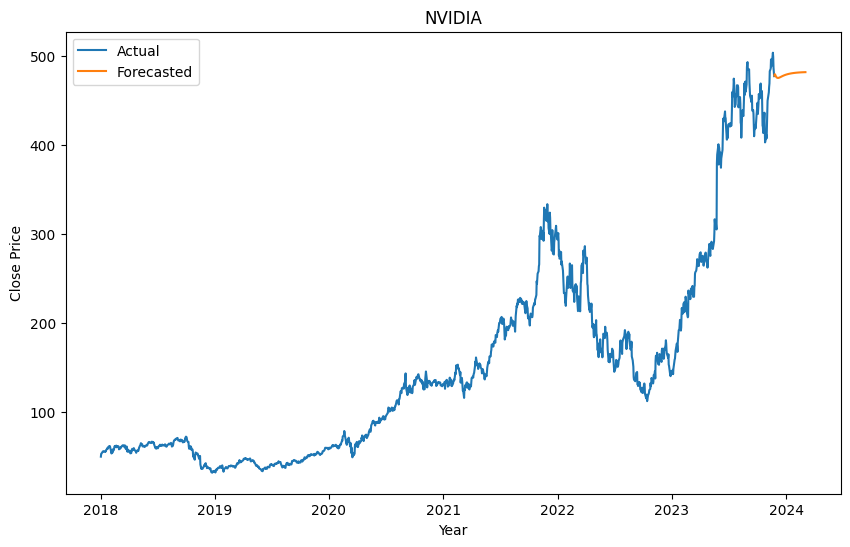

In [48]:
def forecast_visual(df,forecastdf,name):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Close'], label='Actual')
    plt.plot(forecastdf['Date'], forecastdf['Values'], label='Forecasted')
    plt.xlabel('Year')
    plt.ylabel('Close Price')
    plt.title(name)
    plt.legend()
    plt.show()

forecast_visual(data_apple,forecastdf_apple,'APPLE')
forecast_visual(data_google,forecastdf_google,'GOOGLE')
forecast_visual(data_nvidia,forecastdf_nvidia,'NVIDIA')